In [1]:
import matplotlib.pyplot as pl
import matplotlib.colors as colors

import xarray as xr
import numpy as np
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from haversine import inverse_haversine, Direction

import helpers as hlp
from spatial_tools import Projection

In [2]:
"""
Read LES results.
"""
path = '/home/scratch1/bart/microhh/papers/dust_mahrooz_dirk/v2/large/'

# Read post-processed cross-sections.
ds1 = xr.open_dataset(f'{path}/20220510/stats.xy.nc', decode_times=False)
ds2 = xr.open_dataset(f'{path}/20220622/stats.xy.nc', decode_times=False)

In [3]:
"""
Spatial projection used by LES.
"""

xsize = 76800
ysize = 76800
itot = 768
jtot = 768

proj1 = Projection(
        xsize = xsize,
        ysize = ysize,
        itot = itot,
        jtot = jtot,
        lon = 7.4,
        lat = 53.05,
        anchor = 'center')

proj2 = Projection(
        xsize = xsize,
        ysize = ysize,
        itot = itot,
        jtot = jtot,
        lon = 6.5,
        lat = 53.1,
        anchor = 'center')

margin = 0.01
extent1 = [proj1.lon.min()-margin, proj1.lon.max()+margin-0.25, proj1.lat.min()-margin+0.05, proj1.lat.max()+margin-0.10]
extent2 = [proj2.lon.min()-margin+0.25, proj2.lon.max()+margin, proj2.lat.min()-margin+0.04, proj2.lat.max()+margin-0.11]

In [4]:
"""
Plot deposition maps.
"""
zoom_level = 8
cmap = hlp.get_cmap_wbyr()
cmapa = hlp.add_transparancy_to_cmap(cmap, p=0.3)


def plot_bsne_normed(ds, proj, size, sp, extent, normed=False, labels=['bottom', 'left']):
    """
    Plot single panel, optionally normalized with virtual BSNE concentration at 1.
    """
    norm = colors.LogNorm(vmin=1e-3, vmax=1e6)
    var = 'deposition_n' if normed else 'deposition'

    ax = hlp.setup_map(extent, sp=sp, zoom_level=zoom_level, use_osm=True)
    pl.title(rf'{size} $\mu$m', loc='left')
    pc=pl.pcolormesh(proj.lon, proj.lat, -ds[f'{size}um_{var}'], cmap=cmapa, norm=norm, transform=ccrs.PlateCarree())

    # Add lat/lon labels and grid lines.
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5,
        color='gray',
        alpha=0.5,
        linestyle=':')
    
    for side in ['top', 'bottom', 'left', 'right']:
        setattr(gl, f'{side}_labels', side in labels)

    # Add scale indicator.
    start = (extent[2] + 0.9 * (extent[3] - extent[2]), extent[0] + 0.1 * (extent[1] - extent[0]))
    end = inverse_haversine(start, 20, Direction.EAST)

    x = np.array([start[1], end[1]])
    y = np.array([start[0], end[0]])

    pl.plot(x, y, 'k-|', linewidth=1, transform=ccrs.PlateCarree())
    pl.text(x.mean(), y.mean() + 0.01 * (extent[3] - extent[2]), '20 km', ha='center', transform=ccrs.PlateCarree())

    return pc


def plot_local_normed(ds, proj, mask, size, sp, extent, labels=['bottom', 'left']):
    """
    Plot single panel, with deposition normalized by the 500 m radius mean deposition.
    """
    cnorm = colors.LogNorm(vmin=1e-2, vmax=100)

    ax = hlp.setup_map(extent, sp=sp, zoom_level=zoom_level, use_osm=True)
    pl.title(rf'{size} $\mu$m', loc='left')

    field = -ds[f'{size}um_deposition'].values
    norm = field[mask].mean()

    pc=pl.pcolormesh(proj.lon, proj.lat, (field/norm)*100, cmap=cmapa, norm=cnorm, transform=ccrs.PlateCarree())

    # Add lat/lon labels and grid lines.
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5,
        color='gray',
        alpha=0.5,
        linestyle=':')
    
    for side in ['top', 'bottom', 'left', 'right']:
        setattr(gl, f'{side}_labels', side in labels)

    # Add scale indicator.
    start = (extent[2] + 0.9 * (extent[3] - extent[2]), extent[0] + 0.1 * (extent[1] - extent[0]))
    end = inverse_haversine(start, 20, Direction.EAST)

    x = np.array([start[1], end[1]])
    y = np.array([start[0], end[0]])

    pl.plot(x, y, 'k-|', linewidth=1, transform=ccrs.PlateCarree())
    pl.text(x.mean(), y.mean() + 0.01 * (extent[3] - extent[2]), '20 km', ha='center', transform=ccrs.PlateCarree())

    return pc

## No normalization.

Each dust size has a surface flux of 1 kg dust / m2 / s, no normalization applied.

Text(0, 0.5, '24 h total deposition ($\\mu g$ m$^{-2}$)')

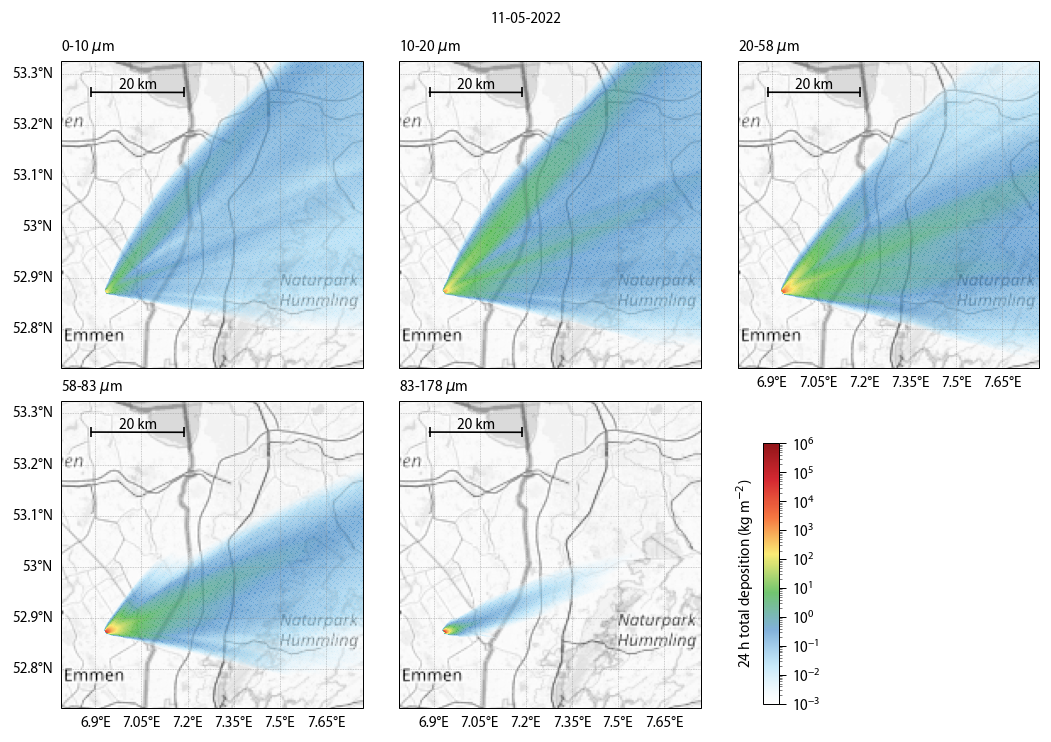

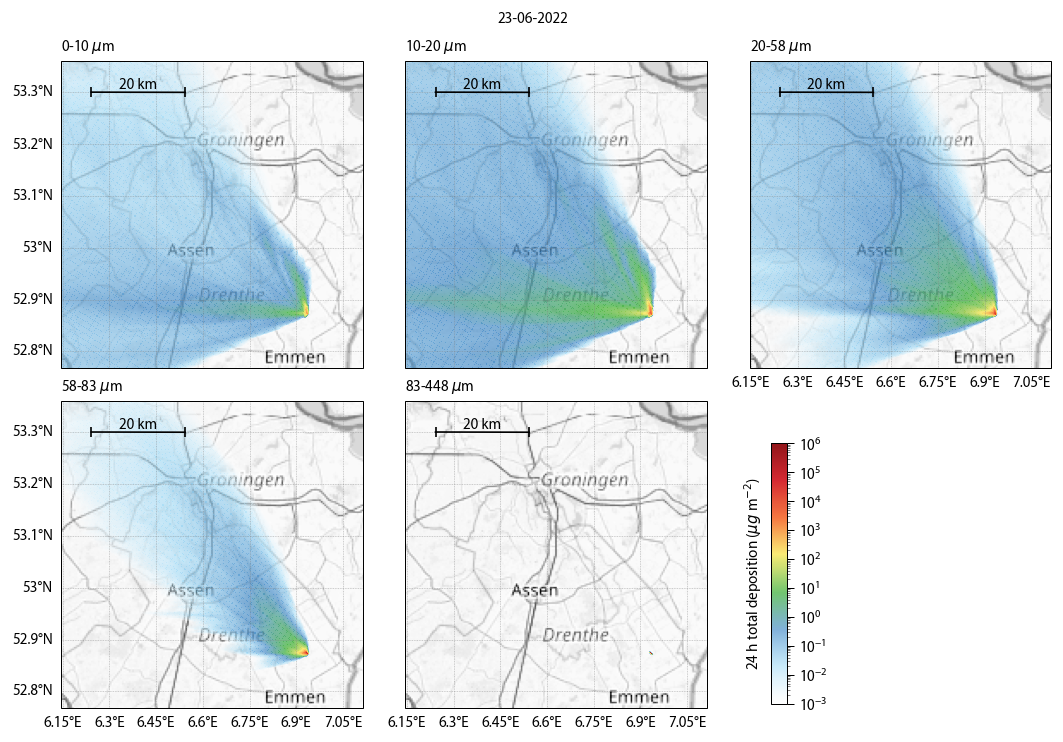

In [5]:
normalized = False

fig=pl.figure(figsize=(9, 6.2))
pl.suptitle('11-05-2022')

pc=plot_bsne_normed(ds1, proj1, '0-10',   231, extent1, normed=normalized, labels=['left'])
pc=plot_bsne_normed(ds1, proj1, '10-20',  232, extent1, normed=normalized, labels=[])
pc=plot_bsne_normed(ds1, proj1, '20-58',  233, extent1, normed=normalized, labels=['bottom'])
pc=plot_bsne_normed(ds1, proj1, '58-83',  234, extent1, normed=normalized, labels=['left', 'bottom'])
pc=plot_bsne_normed(ds1, proj1, '83-178', 235, extent1, normed=normalized, labels=['bottom'])

pl.tight_layout()

cax = fig.add_axes([0.72, 0.05, 0.015, 0.35])
cb = pl.colorbar(pc, cax=cax)
cb.ax.yaxis.set_label_position('left')
cb.ax.set_ylabel(r'24 h total deposition (kg m$^{-2}$)', rotation=90)


fig=pl.figure(figsize=(9, 6.2))
pl.suptitle('23-06-2022')

pc=plot_bsne_normed(ds2, proj2, '0-10',   231, extent2, normed=normalized, labels=['left'])
pc=plot_bsne_normed(ds2, proj2, '10-20',  232, extent2, normed=normalized, labels=[])
pc=plot_bsne_normed(ds2, proj2, '20-58',  233, extent2, normed=normalized, labels=['bottom'])
pc=plot_bsne_normed(ds2, proj2, '58-83',  234, extent2, normed=normalized, labels=['left', 'bottom'])
pc=plot_bsne_normed(ds2, proj2, '83-448', 235, extent2, normed=normalized, labels=['bottom'])

pl.tight_layout()

cax = fig.add_axes([0.72, 0.05, 0.015, 0.35])
cb = pl.colorbar(pc, cax=cax)
cb.ax.yaxis.set_label_position('left')
cb.ax.set_ylabel(r'24 h total deposition ($\mu g$ m$^{-2}$)', rotation=90)

## BSNE normalization.

Each dust size has a surface flux of 1 kg dust / m2 / s.

From the virtual BSNE, we calculate the 24h mean concentration, and normalize all other concentrations such that the virtual BSNE concentration equals 1.0 for each dust size.

NOTE: I don't have high-resolution (field scale) simulations here, so the normalization is done using the low-resolution simulation, and scalar concentrations at the lowest model level = 10 m height.

Text(0, 0.5, '24 h total deposition ($\\mu g$ m$^{-2}$)')

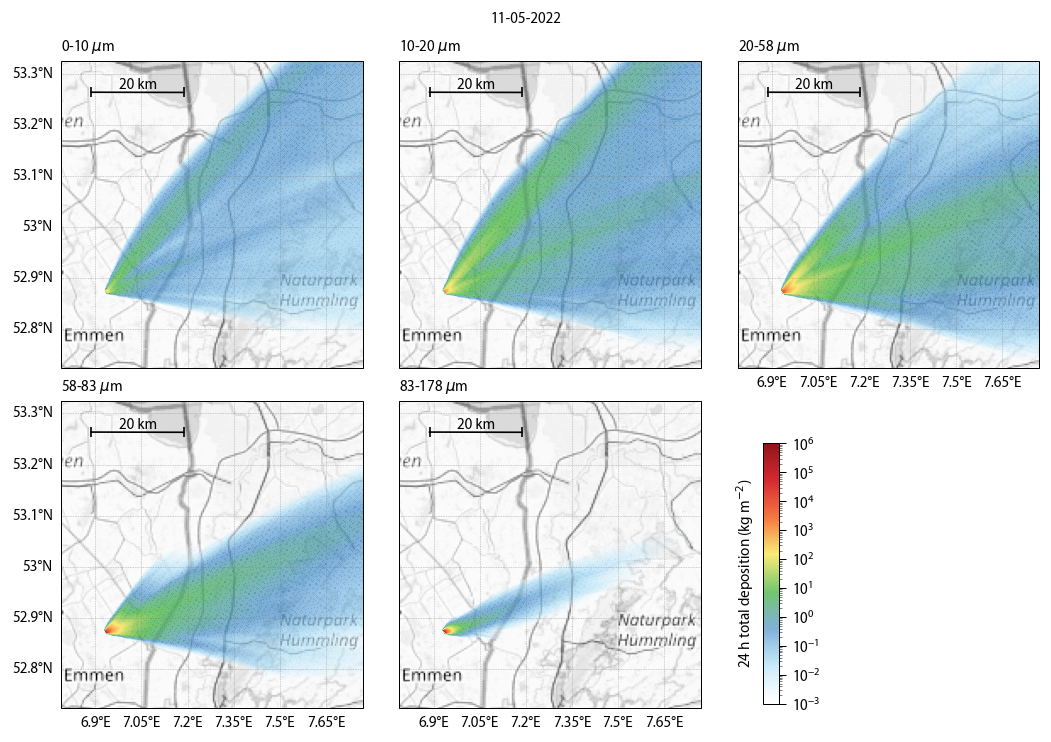

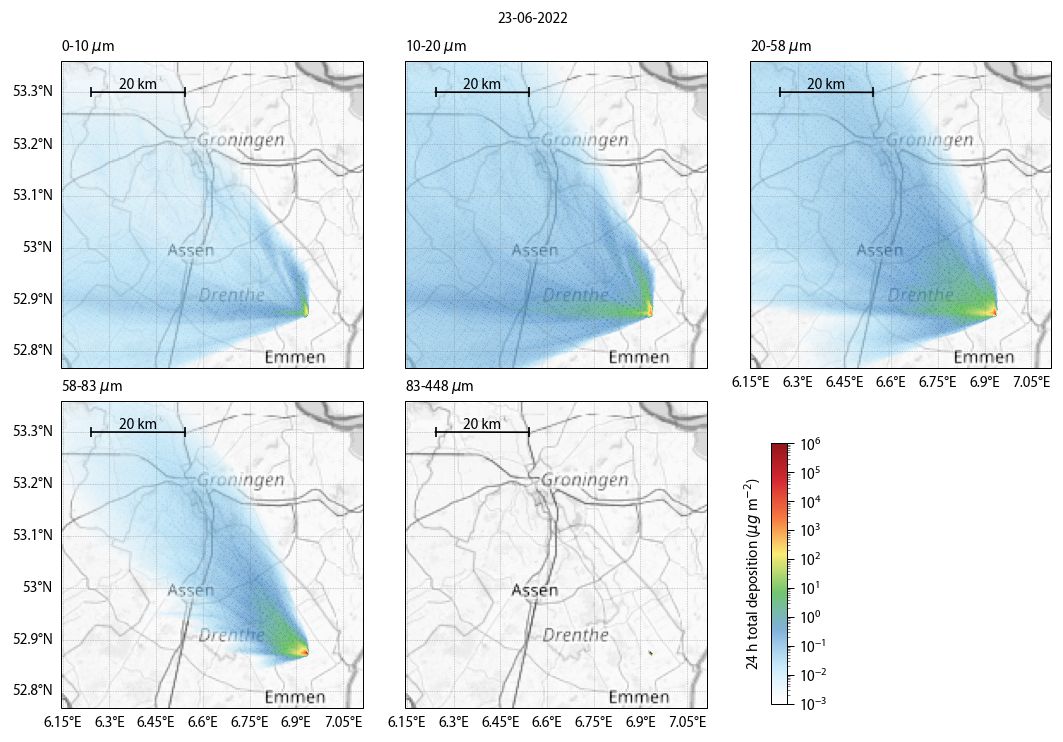

In [6]:
normalized = True

fig=pl.figure(figsize=(9, 6.2))
pl.suptitle('11-05-2022')

pc=plot_bsne_normed(ds1, proj1, '0-10',   231, extent1, normed=normalized, labels=['left'])
pc=plot_bsne_normed(ds1, proj1, '10-20',  232, extent1, normed=normalized, labels=[])
pc=plot_bsne_normed(ds1, proj1, '20-58',  233, extent1, normed=normalized, labels=['bottom'])
pc=plot_bsne_normed(ds1, proj1, '58-83',  234, extent1, normed=normalized, labels=['left', 'bottom'])
pc=plot_bsne_normed(ds1, proj1, '83-178', 235, extent1, normed=normalized, labels=['bottom'])

pl.tight_layout()

cax = fig.add_axes([0.72, 0.05, 0.015, 0.35])
cb = pl.colorbar(pc, cax=cax)
cb.ax.yaxis.set_label_position('left')
cb.ax.set_ylabel(r'24 h total deposition (kg m$^{-2}$)', rotation=90)


fig=pl.figure(figsize=(9, 6.2))
pl.suptitle('23-06-2022')

pc=plot_bsne_normed(ds2, proj2, '0-10',   231, extent2, normed=normalized, labels=['left'])
pc=plot_bsne_normed(ds2, proj2, '10-20',  232, extent2, normed=normalized, labels=[])
pc=plot_bsne_normed(ds2, proj2, '20-58',  233, extent2, normed=normalized, labels=['bottom'])
pc=plot_bsne_normed(ds2, proj2, '58-83',  234, extent2, normed=normalized, labels=['left', 'bottom'])
pc=plot_bsne_normed(ds2, proj2, '83-448', 235, extent2, normed=normalized, labels=['bottom'])

pl.tight_layout()

cax = fig.add_axes([0.72, 0.05, 0.015, 0.35])
cb = pl.colorbar(pc, cax=cax)
cb.ax.yaxis.set_label_position('left')
cb.ax.set_ylabel(r'24 h total deposition ($\mu g$ m$^{-2}$)', rotation=90)

## Local normalization.

Each dust size has a surface flux of 1 kg dust / m2 / s.

For each dust size, we calculate the 24 h mean deposition within a 500 m radius around the center of the field, and normalize the deposition with this value. 

In [7]:
"""
Calculate distance from center of field.
"""

lat_field = np.array([52.875833, 52.875278, 52.870833, 52.871389])
lon_field = np.array([6.932500, 6.931667, 6.937500, 6.938333])

central_lat = lat_field.mean()
central_lon = lon_field.mean()

def haversine_np(lon1, lat1, lon2, lat2):
    lon1 = np.radians(lon1)
    lon2 = np.radians(lon2)
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    
    c = 2 * np.arcsin(np.sqrt(a))
    return 6378137 * c

d1 = haversine_np(central_lon, central_lat, proj1.lon, proj1.lat)
d2 = haversine_np(central_lon, central_lat, proj2.lon, proj2.lat)

radius = 500   # m
mask1 = d1 < radius
mask2 = d2 < radius

Text(0, 0.5, '24 h relative deposition (%)')

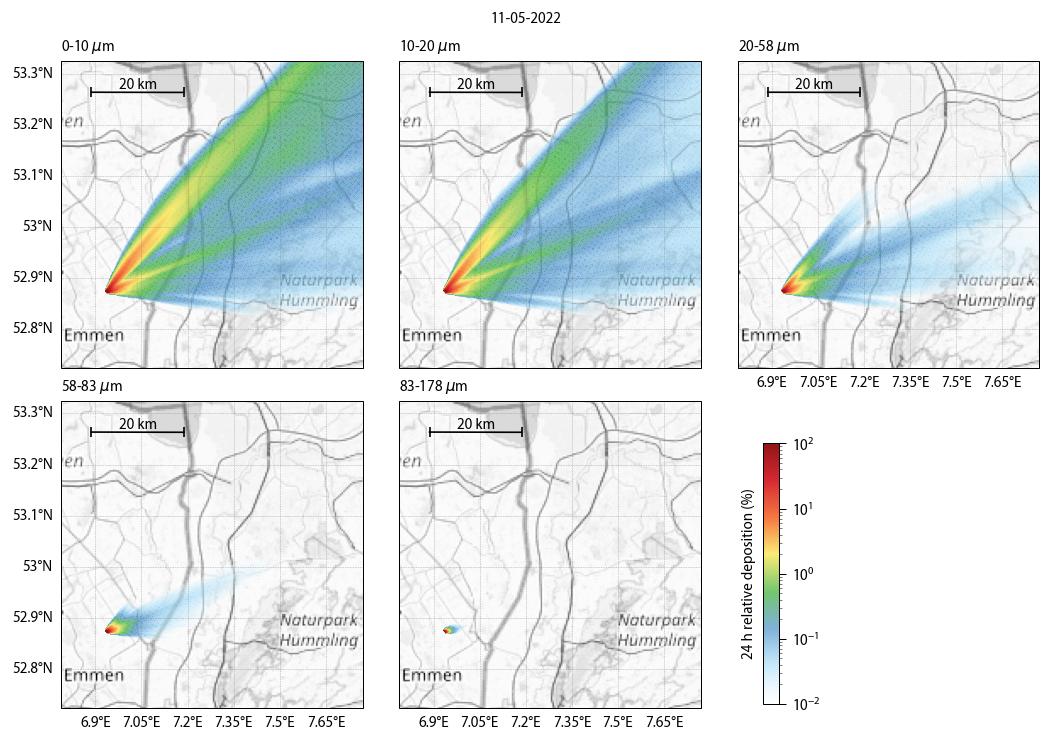

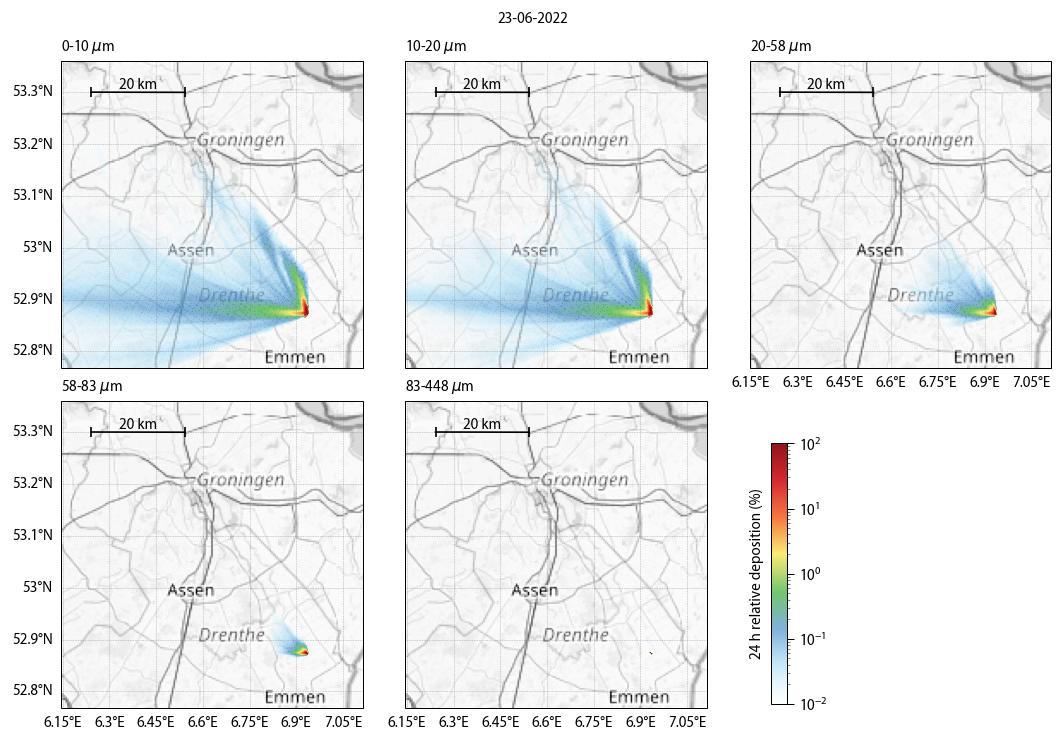

In [8]:
fig=pl.figure(figsize=(9, 6.2))
pl.suptitle('11-05-2022')

pc=plot_local_normed(ds1, proj1, mask1, '0-10',   231, extent1, labels=['left'])
pc=plot_local_normed(ds1, proj1, mask1, '10-20',  232, extent1, labels=[])
pc=plot_local_normed(ds1, proj1, mask1, '20-58',  233, extent1, labels=['bottom'])
pc=plot_local_normed(ds1, proj1, mask1, '58-83',  234, extent1, labels=['left', 'bottom'])
pc=plot_local_normed(ds1, proj1, mask1, '83-178', 235, extent1, labels=['bottom'])

pl.tight_layout()

cax = fig.add_axes([0.72, 0.05, 0.015, 0.35])
cb = pl.colorbar(pc, cax=cax)
cb.ax.yaxis.set_label_position('left')
cb.ax.set_ylabel(r'24 h relative deposition (%)', rotation=90)


fig=pl.figure(figsize=(9, 6.2))
pl.suptitle('23-06-2022')

pc=plot_local_normed(ds2, proj2, mask2, '0-10',   231, extent2, labels=['left'])
pc=plot_local_normed(ds2, proj2, mask2, '10-20',  232, extent2, labels=[])
pc=plot_local_normed(ds2, proj2, mask2, '20-58',  233, extent2, labels=['bottom'])
pc=plot_local_normed(ds2, proj2, mask2, '58-83',  234, extent2, labels=['left', 'bottom'])
pc=plot_local_normed(ds2, proj2, mask2, '83-448', 235, extent2, labels=['bottom'])

pl.tight_layout()

cax = fig.add_axes([0.72, 0.05, 0.015, 0.35])
cb = pl.colorbar(pc, cax=cax)
cb.ax.yaxis.set_label_position('left')
cb.ax.set_ylabel(r'24 h relative deposition (%)', rotation=90)